In [1]:
import pennylane as qml                  # Quantum circuit builder and device management
from pennylane import numpy as np        # Not regular NumPy, but similar and supports automatic differentiation
from pennylane import qchem              # Quantum chemistry module used to define molecule Hamiltonians
# from pennylane.qchem import excitations  # Single and double excitations used in the UCCSD (Unitary Coupled Cluster Singles and Doubles) ansatz
import matplotlib.pyplot as plt
import os

In [2]:
"""
Implementation of the noiseless VQE algorithm to find the ground state of dihydrogen (H₂) using both single and double excitations.

Multiple ansatzes are used and compared.
"""

'\nImplementation of the noiseless VQE algorithm to find the ground state of dihydrogen (H₂) using both single and double excitations.\n\nMultiple ansatzes are used and compared.\n'

In [3]:
# Define the atoms in the dihydrogen molecule
symbols = ["H", "H"]

# Define the coordinates (in Ångströms)
coordinates = np.array([
    [0.0000, 0.0000, 0.0000],  # Hydrogen 1
    [0.0000, 0.0000, 0.7414]   # Hydrogen 2
])

# Define the dihydrogen Hamiltonian and the number of qubits required
# Default STO-3G basis set
hamiltonian, qubits = qchem.molecular_hamiltonian(symbols, coordinates, charge=0)

# Define the number of required quantum wires / logical qubits
num_wires = qubits

# Create quantum device simulator backend
dev = qml.device("default.qubit",  # Noiseless state vector simulator
                 wires=num_wires)

In [4]:
def uccsd_ansatz(params, wires):
    # Example UCCSD for H2 in minimal basis (1 parameter)
    qml.RY(params[0], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(-params[0], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])


def ry_cz_ansatz(params, wires):
    for i in range(len(wires)):
        qml.RY(params[i], wires=wires[i])
    for i in range(len(wires) - 1):
        qml.CZ(wires=[wires[i], wires[i + 1]])


def minimal_one_param_ansatz(params, wires):
    qml.RY(params[0], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])


def hardware_efficient_ansatz(params, wires):
    qml.templates.BasicEntanglerLayers(params, wires=wires)


ansatzes = {
    "UCCSD": uccsd_ansatz,
    "RY-CZ": ry_cz_ansatz,
    "Minimal": minimal_one_param_ansatz,
    # "HardwareEfficient": hardware_efficient_ansatz,
}


def create_circuit(ansatz_fn, wires):
    @qml.qnode(dev)
    def circuit(params):
        ansatz_fn(params, wires=wires)
        return qml.expval(hamiltonian)
    return circuit

In [5]:
# Run VQE for each ansatz
results = {}
max_iters = 40
stepsize = 0.2

for name, ansatz_fn in ansatzes.items():
    print(f"\nRunning VQE with {name} Ansatz...")
    
    circuit = create_circuit(ansatz_fn, wires=[0, 1])
    cost = lambda p: circuit(p)
    
    # Guess parameter count based on ansatz name
    if name in ["UCCSD", "Minimal"]:
        num_params = 1
    elif name == "RY-CZ":
        num_params = 2
    else:
        num_params = 6  # 3 layers for 2 wires (3x2)

    init_params = 0.01 * np.random.randn(num_params)
    opt = qml.AdamOptimizer(stepsize=stepsize)
    
    params = init_params
    energy_progress = []

    for i in range(max_iters):
        params = opt.step(cost, params)
        energy = cost(params)
        energy_progress.append(energy)

    results[name] = {
        "final_energy": energy,
        "params": params,
        "trajectory": energy_progress,
    }

    print(f"Final energy for {name}: {energy:.8f} Ha")


Running VQE with UCCSD Ansatz...
Final energy for UCCSD: -0.87976582 Ha

Running VQE with RY-CZ Ansatz...
Final energy for RY-CZ: -0.87927354 Ha

Running VQE with Minimal Ansatz...
Final energy for Minimal: -0.84819342 Ha


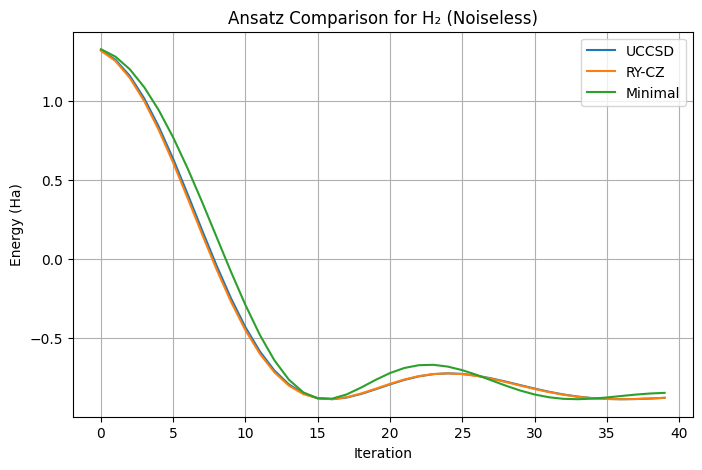

In [6]:
plt.figure(figsize=(8, 5))
for name, data in results.items():
    plt.plot(data["trajectory"], label=name)

plt.xlabel("Iteration")
plt.ylabel("Energy (Ha)")
plt.title("Ansatz Comparison for H₂ (Noiseless)")
plt.legend()
plt.grid(True)

# Save the figure to the "images" directory
os.makedirs("images", exist_ok=True)
plt.savefig('images/H2_Ansatz_Comparison.png')
plt.show()